In [ ]:
# Code adapted from https://github.com/hlamba28/One-Shot-Learning-with-Siamese-Networks

In [21]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rng
import os
import pickle
import time
from imageio import imread
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from metric_learn import ITML



In [2]:
# Global file paths
root_path = ""
train_folder = root_path + "images_background/"
val_folder = root_path + "images_evaluation/"
save_path = root_path + "data/"

# Upload dataset, creating and saving image tensors (only needs to be run once)

In [3]:
def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X = []
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y, None]
        alphabet_path = os.path.join(path, alphabet)

        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images = []
            letter_path = os.path.join(alphabet_path, letter)
            
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
            
    y = np.vstack(y)
    X = np.stack(X)
    return X, y, lang_dict

In [4]:
# # Loading training and validation images into tensors
# X_train, y_train, c_train = loadimgs(train_folder)
# X_val, y_val, c_val = loadimgs(val_folder)

# # Saving training and validation tensors onto disk
# with open(os.path.join(save_path,"train.pickle"), "wb") as f:
#     pickle.dump((X_train, c_train), f)

# with open(os.path.join(save_path,"val.pickle"), "wb") as f:
#     pickle.dump((X_val, c_val), f)

# Loading training and validation tensors

In [5]:
with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (X_train, train_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(train_classes.keys()))
print("\n")


with open(os.path.join(save_path, "val.pickle"), "rb") as f:
    (X_val, val_classes) = pickle.load(f)

print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Training alphabets: 

['Gujarati', 'Korean', 'Arcadian', 'Malay_(Jawi_-_Arabic)', 'Grantha', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Balinese', 'Futurama', 'N_Ko', 'Burmese_(Myanmar)', 'Anglo-Saxon_Futhorc', 'Mkhedruli_(Georgian)', 'Latin', 'Braille', 'Sanskrit', 'Japanese_(hiragana)', 'Tagalog', 'Greek', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Japanese_(katakana)', 'Early_Aramaic', 'Hebrew', 'Tifinagh', 'Asomtavruli_(Georgian)', 'Armenian', 'Syriac_(Estrangelo)', 'Alphabet_of_the_Magi', 'Cyrillic', 'Bengali', 'Inuktitut_(Canadian_Aboriginal_Syllabics)']


Validation alphabets:

['Oriya', 'ULOG', 'Tengwar', 'Malayalam', 'Atlantean', 'Keble', 'Manipuri', 'Gurmukhi', 'Tibetan', 'Aurek-Besh', 'Ge_ez', 'Angelic', 'Old_Church_Slavonic_(Cyrillic)', 'Kannada', 'Avesta', 'Mongolian', 'Syriac_(Serto)', 'Atemayar_Qelisayer', 'Sylheti', 'Glagolitic']


In [8]:
# def get_batch(batch_size, s="train"):
#     """Create batch of n pairs, half same class, half different class"""
    
#     if s == 'train':
#         X = X_train
#         categories = train_classes
#     else:
#         X = X_val
#         categories = val_classes
        
#     n_classes, n_examples, w, h = X.shape

#     # Randomly sample several classes to use in the batch
#     categories = rng.choice(n_classes, size=(batch_size,), replace=False)
    
#     pairs = [np.zeros((batch_size, h, w, 1)) for i in range(2)]    
#     targets = np.zeros((batch_size,))
    
#     # Make first half different class, second half same class
#     targets[batch_size // 2:] = 1
#     for i in range(batch_size):
#         category1 = categories[i]
#         if i >= batch_size // 2:
#             category2 = category1  
#         else: 
#             category2 = (category1 + rng.randint(1, n_classes)) % n_classes
            
#         ex1, ex2 = rng.choice(n_examples, size=(2,), replace=False)
#         pairs[0][i, :, :, :] = X[category1, ex1].reshape(w, h, 1)
#         pairs[1][i, :, :, :] = X[category2, ex2].reshape(w, h, 1)
    
#     return pairs, targets

### Data Pre-Processing

In [6]:
class OmniglotDataset(Dataset):

    def __init__(self, X, transform=None):
        self.X = X
        self.transform = transform
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = self.X[idx]
        if self.transform:
            img = self.transform(img)
        return img

In [7]:
batch_size = 80
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [8]:
X_train = X_train.reshape(-1, 105, 105)
X_val = X_val.reshape(-1, 105, 105)

train_dataset = OmniglotDataset(X_train, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [9]:
def convert_to_img(x):
    '''
    Converts the output of the autoencoder network to a batch of images that can be viewed. 
    Essentially reverses the transformation applied to the input dataset. 

    Args:
        x: Output layer of the autoencoder, with the batch size

    Returns:
        x: Viewable image, reshaped to be an array of images.

    '''
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(-1, 1, 105, 105)
    return x

# Making a Grid to print images on screen  
  
def imshow(img, epoch):
    '''
    Converts a torchvision grid to be viewable on matplotlib. 
    Args:
        img: of the type Torchvision.utils.grid(img). 
        epoch: the epoch that this image was recorded on 

    Returns:
        Returns nothing. Plots the Grid.

    '''

    npimg = img.numpy()
    
    plt.figure(num=None, figsize=(8, 6), dpi=150, edgecolor='k')
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("Reconstruction of last minibatch of epoch "+str(epoch))
    
def plot_pair(pair1, pair2):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pair1.reshape(105,105), cmap='gray')
    # img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    # ax2.matshow(img,cmap='gray')
    ax2.matshow(pair2.reshape(105,105), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Train autoencoder

In [10]:
class Autoencoder(nn.Module):
    
    def __init__(self, n=32):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(105*105, 4096, bias=True),
            nn.ReLU(True),
            nn.Linear(4096, 1024, bias=True),
            nn.ReLU(True),
            nn.Linear(1024, n, bias=True),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(n, 1024, bias=True),
            nn.ReLU(True),
            nn.Linear(1024, 4096, bias=True),
            nn.ReLU(True),
            nn.Linear(4096, 105*105, bias=True),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [11]:
def train_autoencoder(num_epochs, dataloader, model, criterion, optimizer):
    loss_curve = []
    t_start = time.time()
    for epoch in range(1, num_epochs+1):
        epoch_loss = 0
        
        for img in dataloader:
            img = img.view(img.size(0), -1).cuda()
            output = model(img)
            loss = criterion(output, img)
            epoch_loss += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        epoch_loss = epoch_loss / len(dataloader)
        loss_curve.append(epoch_loss)
        print('epoch [{}/{}], mean epoch loss:{:.4f}, time elapsed: {:.4f} mins'.format(epoch, num_epochs, epoch_loss, (time.time() - t_start) / 60))
        if epoch % 25 == 0:
            # For every 10 epochs, take the output of the last minibatch of the epoch and print the reconstruction.
            pic = convert_to_img(output.cpu().detach())
            imshow(torchvision.utils.make_grid(pic),epoch)
    return model, loss_curve


## Tune learning rate

In [12]:
# num_epochs = 25
# learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
# bottleneck_layer_size = 32
# rec_err = []
# losses = []

# val_dataset = OmniglotDataset(X_val[range(0, X_val.shape[0], 20)], transform=img_transform)
# val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
# val_dataload = iter(val_dataloader)
# val_imgs = val_dataload.next()
# val_imgs = val_imgs.view(val_imgs.size(0), -1).cuda()

# for lr in learning_rates:
#     print('-------TRAINING WITH LEARNING RATE ------ ', lr)
    
#     model = Autoencoder(bottleneck_layer_size).cuda()
#     criterion = nn.MSELoss() 
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#     trained_model, loss_curve = train_autoencoder(num_epochs, train_dataloader, model, criterion, optimizer)
    
#     recon_imgs = model(val_imgs)
#     recon_error = criterion(recon_imgs, val_imgs)
#     rec_err.append(recon_error)
#     losses.append(loss_curve)

In [13]:
# '''Learning curves for all learning rates''' 

# epochs = np.arange(num_epochs)
# plt.figure()
# count = 0
# for curve in losses:
#     plt.plot(epochs, curve, label='lr'+str(learning_rates[count]))
#     count += 1
# plt.title("Loss vs num Epochs")
# plt.legend()
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.show()

# ''' Reconstruction Error vs Learning Rate '''

# plt.figure()
# plt.plot(rec_err)
# plt.title("Reconstruction error vs size of bottleneck layer")
# plt.xlabel("Learning rate")
# plt.ylabel("Reconstruction Error")
# plt.xticks(np.arange(6), learning_rates)
# plt.show()

## Tune bottleneck layer size

In [14]:
# num_epochs = 25 #TODO: Give a suitable number 
# learning_rate = 1e-5 #TODO: Give a suitable number 

# bottleneck_layer_size = [32, 64, 128, 256, 512, 1024] #TODO: Insert a list of bottleneck layer sizes to train the network on

# rec_err = [] # List of reconstruction errors to be obtained for the multiple sizes
# losses = [] # List of training curves to be obtained for the multiple sizes


# for size in bottleneck_layer_size:
#     print('-------TRAINING WITH HIDDEN LAYER SIZE ------ ', size)
    
#     model = Autoencoder(size).cuda()
#     criterion = nn.MSELoss() 
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#     trained_model, loss_curve = train_autoencoder(num_epochs, train_dataloader, model, criterion, optimizer)
    
#     recon_imgs = model(val_imgs)
#     recon_error = criterion(recon_imgs, val_imgs)
#     rec_err.append(recon_error)
#     losses.append(loss_curve)

-------TRAINING WITH HIDDEN LAYER SIZE ------  32


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
# '''Learning curves for all bottleneck layers''' 

# epochs = np.arange(num_epochs)
# plt.figure()
# count = 0
# for curve in losses:
#     plt.plot(epochs, curve, label='size'+str(bottleneck_layer_size[count]))
#     count += 1
# plt.title("Loss vs num Epochs")
# plt.legend()
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.show()

# ''' Reconstruction Error vs Hidden layer size '''

# plt.figure()
# plt.plot(bottleneck_layer_size,rec_err)
# plt.title("Reconstruction error vs size of bottleneck layer")
# plt.xlabel("Bottleneck layer size")
# plt.ylabel("Reconstruction Error")
# plt.show()

## Train optimal autoencoder

In [23]:
# learning_rate = 1e-5
# size = 512
# num_epochs = 25

# model = Autoencoder(size).cuda()
# criterion = nn.MSELoss() 
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# trained_autoencoder, trained_ae_loss_curve = train_autoencoder(num_epochs, train_dataloader, model, criterion, optimizer)

AssertionError: Torch not compiled with CUDA enabled

### Save trained autoencoder

In [ ]:
# torch.save(trained_autoencoder.state_dict(), save_path + "trained_autoencoder")

### Load trained autoencoder

In [16]:
bneck_size = 512
trained_autoencoder = Autoencoder(size)
trained_autoencoder.load_state_dict(torch.load(save_path + "trained_autoencoder"))
trained_autoencoder.eval()

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location='cpu' to map your storages to the CPU.

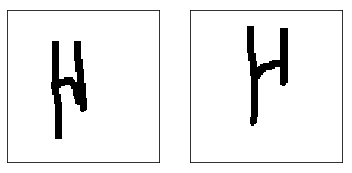

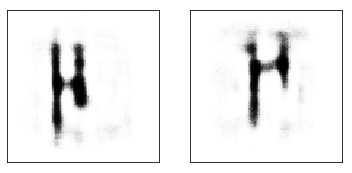

In [85]:
# Sanity check!
val_dataset = OmniglotDataset(X_val, transform=img_transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
plot_pair(val_dataset[0].view(-1, 105, 105), val_dataset[1].view(-1, 105, 105))

# t1 = val_dataset[0].view(-1, 105*105).cuda()
# t2 = val_dataset[1].view(-1, 105*105).cuda()
t1 = img_transform(X_val[0]).cuda().view(-1, 105*105)
t2 = img_transform(X_val[1]).cuda().view(-1, 105*105)
out1 = trained_autoencoder(t1)
out2 = trained_autoencoder(t2)
p1 = convert_to_img(out1)
p2 = convert_to_img(out2)
plot_pair(p1.cpu().detach(), p2.cpu().detach())

# Perform N-way one-shot tasks

In [152]:
def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    
    if s == 'train':
        X = X_train
        categories = train_classes
    else:
        X = X_val
        categories = val_classes
    
        
    X = X.reshape(-1, 20, 105, 105)
    n_classes, n_examples, w, h = X.shape
    
    indices = rng.choice(n_examples, size=(N,))
    
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low, high), size=(N,), replace=False)
        
    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes), size=(N,), replace=False)            
    
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples, size=(2,), replace=False)
    
    test_image = X[true_category, ex1, :, :]
    support_set = X[categories, indices, :, :]
    support_set[0, :] = X[true_category, ex2]
    
    pairs = np.zeros((N, 2, w, h), dtype=X.dtype)
    for i in range(N):
        pairs[i, 0] = test_image
        pairs[i, 1] = support_set[i]
        
    targets = np.zeros((N,))
    targets[0] = 1
    targets, pairs = shuffle(targets, pairs)
    return pairs, targets

In [153]:
def test_oneshot(model, N, n_trials, s="val", verbose=0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(n_trials, N))

    for i in range(n_trials):
        pairs, targets = make_oneshot_task(N, s)
        probs = model.predict(pairs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [88]:
# Hyper parameters
evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 20000 # No. of training iterations
N_way = 20 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

# Baseline model using KNN

In [24]:
def apply_encoding(img):
    img = img_transform(img).view(1, 105*105).cuda()
    encoded_img = trained_autoencoder.encoder(img)
    return encoded_img

In [90]:
def nearest_neighbour_correct(pairs, targets):
    """Returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    
    L2_distances = np.zeros_like(targets)
    
    for i in range(len(targets)):
        pair1 = img_transform(pairs[i, 0]).view(1, 105*105).cuda()
        pair2 = img_transform(pairs[i, 1]).view(1, 105*105).cuda()
        
        encoded_pair1 = trained_autoencoder.encoder(pair1)
        encoded_pair2 = trained_autoencoder.encoder(pair2)

        encoded_pair1 = encoded_pair1.cpu().detach().numpy()
        encoded_pair2 = encoded_pair2.cpu().detach().numpy()
        
        L2_distances[i] = np.sqrt(np.sum(np.square(encoded_pair1 - encoded_pair2)))
        
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [91]:
def test_nn_accuracy(N_ways, n_trials, verbose=True):
    """Returns accuracy of NN approach """
    if verbose:
        print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials, N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs, targets = make_oneshot_task(N_ways, "val")
        correct = nearest_neighbour_correct(pairs, targets)
        n_right += correct
    return 100.0 * n_right / n_trials


In [342]:
ways = np.arange(1, 20, 2)
trials = 50

nn_accs = []
for N in ways:    
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("---------------------------------------------------------------------------------------------------------------")

Evaluating nearest neighbour on 50 unique 1 way one-shot learning tasks ...
NN Accuracy =  100.0
---------------------------------------------------------------------------------------------------------------
Evaluating nearest neighbour on 50 unique 3 way one-shot learning tasks ...
NN Accuracy =  60.0
---------------------------------------------------------------------------------------------------------------
Evaluating nearest neighbour on 50 unique 5 way one-shot learning tasks ...
NN Accuracy =  56.0
---------------------------------------------------------------------------------------------------------------
Evaluating nearest neighbour on 50 unique 7 way one-shot learning tasks ...
NN Accuracy =  52.0
---------------------------------------------------------------------------------------------------------------
Evaluating nearest neighbour on 50 unique 9 way one-shot learning tasks ...
NN Accuracy =  40.0
-----------------------------------------------------------------------

## Performance compared as number of trials increases

In [330]:
trials = [50, 100, 250, 500, 1000, 2500, 5000]
curves = []
for t in trials:
    nn_accs = []
    print ("Trial = ", t)
    print("---------------------------------------------------------------------------------------------------------------")
    for N in ways:    
        nn_acc = test_nn_accuracy(N, 100, verbose=False)
        nn_accs.append(nn_acc)
    curves.append(nn_accs)

Trial =  50
---------------------------------------------------------------------------------------------------------------
Trial =  100
---------------------------------------------------------------------------------------------------------------
Trial =  250
---------------------------------------------------------------------------------------------------------------
Trial =  500
---------------------------------------------------------------------------------------------------------------
Trial =  1000
---------------------------------------------------------------------------------------------------------------
Trial =  2500
---------------------------------------------------------------------------------------------------------------
Trial =  5000
---------------------------------------------------------------------------------------------------------------


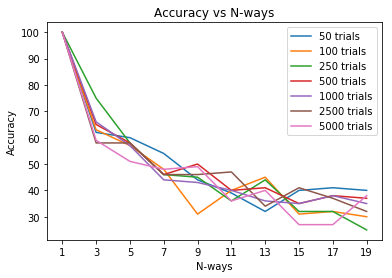

In [337]:
'''Accuracy curve for all no. of trials''' 

plt.figure()
count = 0
for curve in curves:
    plt.plot(ways, curve, label=str(trials[count]) + ' trials')
    count += 1
plt.title("Accuracy vs N-ways")
plt.legend()
plt.xlabel("N-ways")
plt.ylabel("Accuracy")
plt.xticks(ways)
plt.show()

# Train ITML


In [42]:
def get_batch(batch_size, s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == "train":
        X = X_train
        categories = train_classes
    else:
        X = X_val
        categories = val_classes
    X = X.reshape(-1, 20, 105*105)
    n_classes, n_examples, area = X.shape
    
    # Randomly sample several classes to use in the batch
    categories = rng.choice(n_classes, size=(batch_size,), replace=False)
    
    pairs = np.zeros((batch_size, 2, 105*105))
    targets = np.zeros((batch_size,), dtype=np.int8)
    
    # Make first half different class, second half same class
    targets[:batch_size // 2] = -1
    targets[batch_size // 2:] = 1
    
    for i in range(batch_size):
        category1 = categories[i]
        if i >= batch_size // 2:
            category2 = category1  
        else: 
            category2 = (category1 + rng.randint(1 ,n_classes)) % n_classes
        
        ex1, ex2 = rng.choice(n_examples, size=(2,), replace=False)
        pairs[i, 0] = X[category1, ex1].reshape(1, 105*105)
        pairs[i, 1] = X[category2, ex2].reshape(1, 105*105)
#         encoded_pair1 = apply_encoding(X[category1, ex1].reshape(1, 105*105))
#         encoded_pair2 = apply_encoding(X[category2, ex2].reshape(1, 105*105))
        
#         pairs[i, 0] = encoded_pair1.cpu().detach().numpy()
#         pairs[i, 1] = encoded_pair2.cpu().detach().numpy()
        

    return pairs, targets

In [193]:
X_train.shape

(19280, 105, 105)

In [197]:
indices = []
n_classes, n_examples, w, h = X_train.reshape(-1, 20, 105, 105).shape
for i in range(100):
    
    ex1 = rng.randint(n_examples)
    ex2 = rng.randint(n_examples)
    indices.append([i*20+ex1, i*20+ex2]) # First pair is from the same class
    
    # Remaining four pairs are from different classes
    for j in range(4):
        roll = rng.randint(n_classes)
        while roll == i:
            roll = rng.randint(n_classes)
        ex3 = rng.randint(n_examples)
        indices.append([i*20+ex1, roll*20+ex3])

labels = [1,-1,-1,-1,-1]*100
indices, labels = shuffle(indices, labels)

In [200]:
print('-------TRAINING ITML ------ ')
t_start = time.time()
tr = X_train.reshape(-1, 105*105)
itml = ITML(preprocessor=tr)
itml.fit(indices, labels)
print("TIme elapsed: {:4f} mins".format((time.time() - t_start) / 60))

-------TRAINING ITML ------ 


/usr/local/lib/python3.7/site-packages/metric_learn/itml.py:76: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = min(_lambda[i], gamma_proj*(1./wtw - 1./pos_bhat[i]))


TIme elapsed: 20.264683 mins


In [215]:
def test_itml_accuracy(N, trials, model):
    n_right = 0
    
    for i in range(trials):
        pairs, targets = make_oneshot_task(N)
        pairs = pairs.reshape(-1, 2, 105*105)
        pairs, targets = shuffle(pairs, targets)
        scores = model.score_pairs(pairs)
        if np.argmax(scores) == np.argmax(targets):
            n_right += 1
    return n_right * 100 / trials

In [218]:
ways = np.arange(1, 20, 2)
trials = 50

accs = []
for N in ways:    
    acc = test_itml_accuracy(N, trials, itml)
    accs.append(nn_acc)
    print ("{}-way one-shot accuracy = {}".format(N, acc))
    print("---------------------------------------------------------------------------------------------------------------")

1-way one-shot accuracy = 100.0
---------------------------------------------------------------------------------------------------------------
3-way one-shot accuracy = 24.0
---------------------------------------------------------------------------------------------------------------
5-way one-shot accuracy = 10.0
---------------------------------------------------------------------------------------------------------------
7-way one-shot accuracy = 10.0
---------------------------------------------------------------------------------------------------------------
9-way one-shot accuracy = 8.0
---------------------------------------------------------------------------------------------------------------
11-way one-shot accuracy = 6.0
---------------------------------------------------------------------------------------------------------------
13-way one-shot accuracy = 2.0
---------------------------------------------------------------------------------------------------------------

# Helper functions to visualize test image and support set

In [343]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [344]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][11].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    # ax1.get_yaxis().set_visible(False)
    # ax1.get_xaxis().set_visible(False)
    # ax2.matshow(img,cmap='gray')
    ax2.matshow(pairs[1][11].reshape(105,105), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()